<a href="https://colab.research.google.com/github/umaixer/DataScience-ML/blob/master/NLP/Intention%20Recognition%20with%20XLNet%20and%20BERT/Intention_Recognition_XLNet_vs_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTENT RECOGNITION 
with XLNET and BERT using Pytorch

Recognizing intent (IR) from text is very useful these days. Usually, you get a short text (sentence or two) and have to classify it into one (or multiple) categories.

Multiple product support systems (help centers) use IR to reduce the need for a large number of employees that copy-and-paste boring responses to frequently asked questions. Chatbots, automated email responders, answer recommenders (from a knowledge base with questions and answers) strive to not let you take the time of a real person.

**Problem Statement:**
We have to detect one out of seven intents based on the input text, which makes it a multi-class classification problem.   

I am buiding a classifier using XLnet and BERT model with Pytorch. We will then compare the results of these two state of the art models, which are based on transformer model. I will use pre-trained models (implemented by HuggingFace). We will see that these cutting edge algorithms will produce exceptional results.

### **XLNet**

XLNET integrates ideas from Transformer-XL, the state-of-the-art autoregressive model into pretraining. 

Unlike LSTM based model, which reads sequentially in either one or both directions, the transformer reads entire sequences of tokens at once. In a sense, the transformer model is non-directional. The attention mechanism allows for learning contextual relations between words and then encode that context in a rich vector which smartly represents the word in a sentence. 

#### **What is XLNet?** 

XLNET is a generalized autoregressive model where next token is dependent on all previous tokens. XLNET is “generalized” because it captures bi-directional context by means of a mechanism called “permutation language modeling”. It integrates the idea of auto-regressive models and bi-directional context modeling, yet overcoming the disadvantages of BERT. It outperforms BERT on 20 tasks, often by a large margin in tasks such as question answering, natural language inference, sentiment analysis, and document ranking. 

PLM is the idea of capturing bidirectional context by training an autoregressive model on all possible permutation of words in a sentence. Instead of fixed left-right or right-left modeling, XLNET maximizes expected log likelihood over all possible permutations of the sequence. In expectation, each position learns to utilize contextual information from all positions thereby capturing bidirectional context.
  
### **Differences b/w XLNet and BERT**

XLNet is a BERT-like model instead of a totally different one. But it is a very promising and potential one. In one word, XLNet is a generalized autoregressive pretraining method. AR language model is a kind of model that using the context word to predict the next word. But here the context word is constrained to two directions, either forward or backward.

BERT is categorized as autoencoder(AE) language model. The AE language model aims to reconstruct the original data from corrupted input. The corrupted input means we use [MASK] to replace the original token into in the pre-train phase. And the objective is to predict into to get the original sentence.

AE language model also has its disadvantages. It uses the [MASK] in the pretraining, but this kind of artificial symbols are absent from the real data at finetuning time, resulting in a pretrain-finetune discrepancy. Another disadvantage of [MASK] is that it assumes the predicted (masked) tokens are independent of each other given the unmasked tokens.

XLNET integrates the idea of auto-regressive models and bi-directional context modeling, yet overcoming the disadvantages of BERT.  XLNET maximizes expected log likelihood over all possible permutations of the sequence. In expectation, each position learns to utilize contextual information from all positions thereby capturing bidirectional context. No [MASK] is needed and input data need not be corrupted. It outperforms BERT on 20 tasks, often by a large margin in tasks such as question answering, natural language inference, sentiment analysis, and document ranking.


#### **Transfer Learning**

In my opinion, the biggest advantage of transformer based models such as BERT and XLNET is that transfer learning has finally been made possible in NLP. BERT is pretrained on Wikipedia articles and thousands of books and it can just be fine tuned on a custom task and it provides exceptional performance.




Importing necessary libraries

In [3]:
import transformers
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.cuda.is_available()

True

## **Importing the dataset**

In [4]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/valid.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [5]:
classes = df_train.intent.unique().tolist()
num_classes = len(classes)

[Text(0, 0, 'PlayMusic'),
 Text(0, 0, 'AddToPlaylist'),
 Text(0, 0, 'RateBook'),
 Text(0, 0, 'SearchScreeningEvent'),
 Text(0, 0, 'BookRestaurant'),
 Text(0, 0, 'GetWeather'),
 Text(0, 0, 'SearchCreativeWork')]

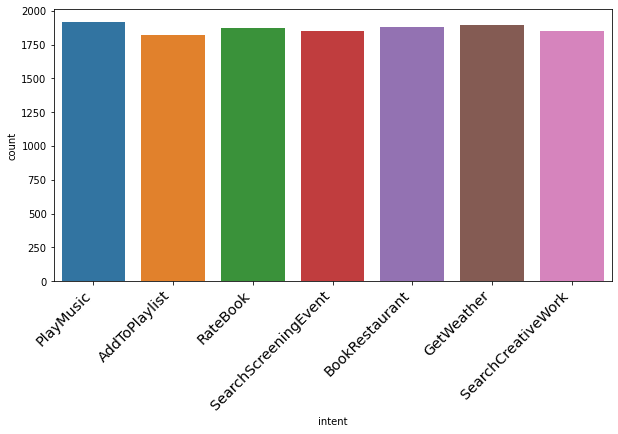

In [6]:
#print(df.info)
plt.figure(figsize=(10,5))
chart = sns.countplot(df_train.intent)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='x-large')


We can see that dataset is almost perfectly balanced, therefore, no need of augmentation

### **Preprocessing and cleaning the data**

In [7]:
def remove_URL(text):
    return re.sub(r'https?://\S+|www\.\S+', '',text)

# Remove square brackets
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Remove html tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)
remove_html("<h1>Vansh Jatana</h1>")

#remove the noisy text
def remove_noise(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_html(text)
    return text

#Apply the remove_noise function 
df_train['text'] = df_train['text'].apply(remove_noise)

**Defining and downloading XLNet Tokenizer.**

In [8]:
tokenizer= transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [9]:
def intent2label(intent):

    if intent == "PlayMusic":
        return 0
    elif intent == "AddToPlaylist": 
        return 1
    elif intent == "RateBook":
        return 2
    elif intent == "SearchScreeningEvent":
        return 3
    elif intent == "BookRestaurant":
        return 4
    elif intent == "GetWeather":
        return 5
    elif intent == "SearchCreativeWork":
        return 6
    
df_train['intent'] = df_train['intent'].apply(intent2label)
df_val['intent'] = df_val['intent'].apply(intent2label)
df_test['intent'] = df_test['intent'].apply(intent2label)

In [10]:
df_train.head()

,text,intent
0,listen to westbam alumb allergic on google music,0
1,add step to me to the 50 clásicos playlist,1
2,i give this current textbook a rating value of...,2
3,play the song little robin redbreast,0
4,please add iris dement to my playlist this is ...,1


**Building Pytorch DataSet**

In [11]:
class Intent_dataset(Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        labels = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          truncation=True,
          return_tensors='pt',
    )
        return {
          'text':text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
    }

Helper function for Pytorch dataloader is defined below

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = Intent_dataset(text = df.text.to_numpy(),
                      labels = df.intent.to_numpy(),
                      tokenizer = tokenizer,
                      max_len = max_len)
    
    return DataLoader(ds, batch_size = batch_size, num_workers = 0)

Implementing DataLoader functions to make the data ready for training and evaluation

In [13]:
BATCH_SIZE = 8
MAX_LEN = 512
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
data = next(iter(train_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [15]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


**Creating XLNet model instance.**

In [ ]:
model_XLnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = num_classes)
model_XLnet = model_XLnet.to(device)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

**XLNet Model Architecture**

In [ ]:
model_XLnet

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

Building the classifier which used the BERT model.

The classifier delegates most of the work to the pre-traiend Bert model. I added the dropout layer for some regularization to avoid over-fitting to the training data and a fully-connected layer for the binary output. 

**Helper function for training the model**

In [22]:
def train_fun(data_loader, model, optimizer, scheduler, device, n_examples):
    
    model = model.train()
    tr_losses = []
    tr_correct_preds = 0
    
    for step, data in tqdm(enumerate(data_loader), total = len(data_loader), position=0, leave=True):
        
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids = ids ,
            attention_mask = mask, 
            labels = labels)
        
        loss = outputs[0]
        logits = outputs[1]

        labels = labels.long()
        _, preds = torch.max(logits, dim=1)
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        tr_correct_preds += np.sum(preds == labels)
        tr_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    return tr_correct_preds/n_examples, np.mean(tr_losses)

**Helper function for evaluating the model**

In [23]:
def eval_fun(data_loader, model, device, n_examples):
    model.eval()
    
    eval_losses = []
    eval_correct_preds = 0
    
    with torch.no_grad():
        for step, data in tqdm(enumerate(data_loader), total = len(data_loader), position=0, leave=True):
          
          ids = data["input_ids"].to(device)
          
          mask = data["attention_mask"].to(device)
          
          labels = data["labels"].to(device)
          
          outputs = model(
            input_ids=ids,
            attention_mask = mask, 
            labels = labels)
        
          loss = outputs[0]
          logits = outputs[1]
          labels = labels.long()
        
          _, preds = torch.max(logits, dim=1)
          
          preds = preds.detach().cpu().numpy()
          
          labels = labels.detach().cpu().numpy()
          
          eval_correct_preds += np.sum(preds == labels)
          
          eval_losses.append(loss.item())
    return  eval_correct_preds/n_examples, np.mean(eval_losses) 
    

## **Training Using XLNet model**
Using the training and evaluation functions, we will implement the training loop.

ADAMW optimizer is utilized as it impelements the weight decay and produce better results.

In [ ]:
EPOCHS = 2
model = model_XLnet

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.Weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0}]


optimizer = AdamW(optimizer_parameters, lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
history = defaultdict(list)


for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    tr_acc, tr_loss = train_fun(train_loader, model, 
                                optimizer, scheduler, device, len(df_train))
    
    print('Training Loss: ' +str(tr_loss) +' Training Accuracy: ' +str(tr_acc*100) +'%')
    
    val_acc, val_loss= eval_fun(val_loader, model, 
                                device, len(df_val))
    
    print('Validation Loss: ' +str(val_loss) +' Validation Accuracy: ' +str(val_acc*100) +'%')

    history['tr_acc'].append(tr_acc)
    history['tr_loss'].append(tr_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

  0%|          | 0/1636 [00:00<?, ?it/s]

Epoch 1/2
----------


  0%|          | 0/88 [00:00<?, ?it/s]

Training Loss: 0.05678089849268312 Training Accuracy: 98.5172730051972%


  0%|          | 0/1636 [00:00<?, ?it/s]

Validation Loss: 0.03844989734617146 Validation Accuracy: 98.42857142857143%
Epoch 2/2
----------


  0%|          | 0/88 [00:00<?, ?it/s]

Training Loss: 0.029135408986605757 Training Accuracy: 99.17456435340874%


100%|██████████| 88/88 [01:45<00:00,  1.20s/it]

Validation Loss: 0.04575503109530969 Validation Accuracy: 98.57142857142858%


### **Training Model Analysis**

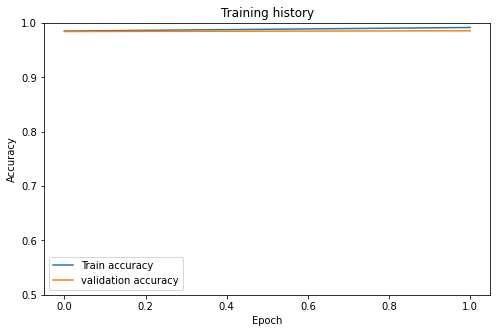

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(history['tr_acc'], label='Train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


## **Evaluation with XLNet**

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
test_acc, test_loss= eval_fun(test_loader, model, 
                                device, len(df_test))

100%|██████████| 88/88 [01:45<00:00,  1.20s/it]


### **Test Accuracy**

In [ ]:
print('Test Accuracy: ' +str(test_acc*100) +'%')

Test Accuracy: 97.85714285714285%


**Defining the prediction function**

In [ ]:
def pred_fun(data_loader, model):
    model.eval()
    
    targets = []
    predictions = []
    
    with torch.no_grad():
      for step, data in enumerate(data_loader):
          
          ids = data["input_ids"].to(device)
          mask = data["attention_mask"].to(device)
          labels = data["labels"].to(device)
          
          outputs = model(
              input_ids = ids,
              attention_mask = mask,
              labels= labels)
          loss = outputs[0]
          logits = outputs[1]
          labels = labels.long()

          _, preds = torch.max(logits, dim=1)
          preds = preds.detach().cpu().numpy()
          labels = labels.detach().cpu().numpy()
          predictions.extend(preds)
          targets.extend(labels)

    predictions = np.stack(predictions)
    targets = np.stack(targets)
    return  predictions, targets 

In [ ]:
y_pred, y_test = pred_fun(test_loader, model)

### **Classification report including the F1 score with XLNet model**

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.98      0.98      0.98        86
       AddToPlaylist       1.00      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       0.99      0.92      0.95       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.90      0.97      0.94       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



### **Confusion Matrix**

[[ 84   0   0   0   0   0   2]
 [  0 124   0   0   0   0   0]
 [  0   0  80   0   0   0   0]
 [  0   0   0  98   0   0   9]
 [  0   0   0   0  92   0   0]
 [  0   0   0   0   1 103   0]
 [  2   0   0   1   0   0 104]]


Text(69.0, 0.5, 'Predicted')

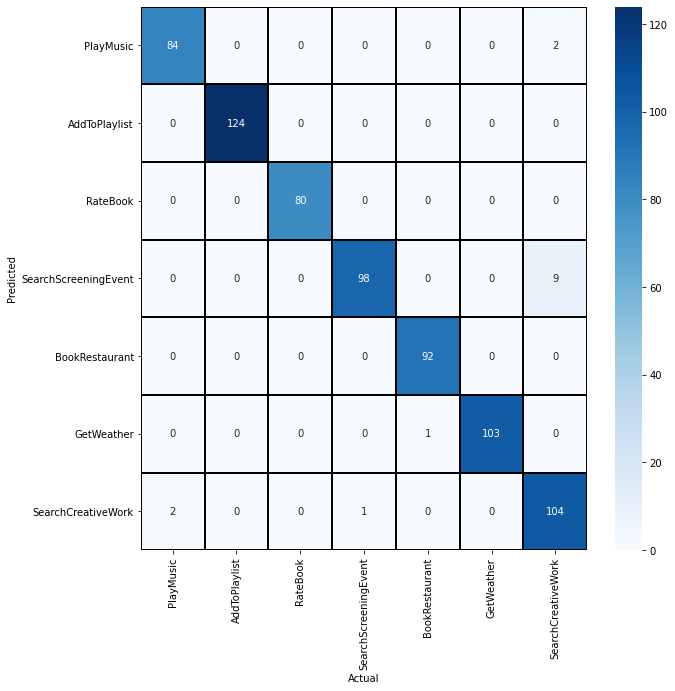

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", xticklabels = classes, 
           yticklabels = classes,
           linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')

98% test accuracy as well as precision proves that pre-trained XLNet model has exceptional performance. 

## **Implementing the Intent Recognition using Pre-trained BERT model**

### **Defining and downloading BERT Tokenizer and Model.**

In [18]:
tokenizer_BERT= BertTokenizer.from_pretrained('bert-base-uncased', 
                                                      do_lower_case=True)
model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_classes)
model_BERT = model_BERT.to(device)

### **Creating data loaders using BERT Tokenizer**

In [20]:
train_loader_BERT = create_data_loader(df_train, tokenizer_BERT, MAX_LEN, BATCH_SIZE)
val_loader_BERT = create_data_loader(df_val, tokenizer_BERT, MAX_LEN, BATCH_SIZE)
test_loader_BERT = create_data_loader(df_test, tokenizer_BERT, MAX_LEN, BATCH_SIZE)

### **Training Using BERT model**

In [24]:
EPOCHS = 2
model = model_BERT

param_optimizer_BERT = list(model.named_parameters())
no_decay_BERT = ['bias', 'LayerNorm.bias', 'LayerNorm.Weight']
optimizer_parameters_BERT = [
    {'params': [p for n, p in param_optimizer_BERT if not any(nd in n for nd in no_decay_BERT)],
        'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer_BERT if any(nd in n for nd in no_decay_BERT)],
        'weight_decay': 0.0}]


optimizer_BERT = AdamW(optimizer_parameters_BERT, lr=2e-5)
total_steps_BERT = len(train_loader_BERT) * EPOCHS
scheduler_BERT = get_linear_schedule_with_warmup(
  optimizer_BERT,
  num_warmup_steps=0,
  num_training_steps=total_steps_BERT
)
history_BERT = defaultdict(list)


for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    tr_acc, tr_loss = train_fun(train_loader_BERT, model_BERT, 
                                optimizer_BERT, scheduler_BERT, device, len(df_train))
    
    print('Training Loss: ' +str(tr_loss) +' Training Accuracy: ' +str(tr_acc*100) +'%')
    
    val_acc, val_loss= eval_fun(val_loader_BERT, model_BERT, 
                                device, len(df_val))
    
    print('Validation Loss: ' +str(val_loss) +' Validation Accuracy: ' +str(val_acc*100) +'%')

    history_BERT['tr_acc'].append(tr_acc)
    history_BERT['tr_loss'].append(tr_loss)
    history_BERT['val_acc'].append(val_acc)
    history_BERT['val_loss'].append(val_loss)

  0%|          | 0/1636 [00:00<?, ?it/s]

Epoch 1/2
----------


  1%|          | 1/88 [00:00<00:12,  6.76it/s]

Training Loss: 0.15625782547778197 Training Accuracy: 96.232039131764%


  0%|          | 0/1636 [00:00<?, ?it/s]

Validation Loss: 0.036894258789040825 Validation Accuracy: 98.85714285714286%
Epoch 2/2
----------


  1%|          | 1/88 [00:00<00:12,  6.81it/s]

Training Loss: 0.02625446660958759 Training Accuracy: 99.28920819321308%


100%|██████████| 88/88 [00:12<00:00,  6.82it/s]

Validation Loss: 0.04286039095710625 Validation Accuracy: 98.71428571428571%


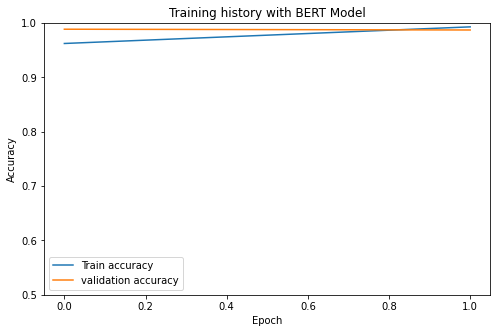

In [62]:
plt.figure(figsize = (8,5))
plt.plot(history_BERT['tr_acc'], label='Train accuracy')
plt.plot(history_BERT['val_acc'], label='validation accuracy')
plt.title('Training history with BERT Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

### **Evaluation with BERT Model**

In [27]:
test_acc, test_loss= eval_fun(test_loader_BERT, model_BERT, 
                                device, len(df_test))

100%|██████████| 88/88 [00:12<00:00,  6.79it/s]


### **Test Accuracy**

In [33]:
print('Test Accuracy: ' +str(test_acc*100) +'%')

Test Accuracy: 96.857142%


In [35]:
y_pred, y_test = pred_fun(test_loader_BERT, model_BERT)

### **Classification report including the F1 score with BERT model**

In [61]:
print(classification_report(y_test, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.96      0.95      0.96        86
       AddToPlaylist       0.99      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       1.00      0.89      0.94       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.87      0.97      0.92       107

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



### **Confusion Matrix**

[[ 82   1   0   0   0   0   3]
 [  0 124   0   0   0   0   0]
 [  0   0  80   0   0   0   0]
 [  0   0   0  95   0   0  12]
 [  0   0   0   0  92   0   0]
 [  0   0   0   0   1 103   0]
 [  3   0   0   0   0   0 104]]


Text(69.0, 0.5, 'Predicted')

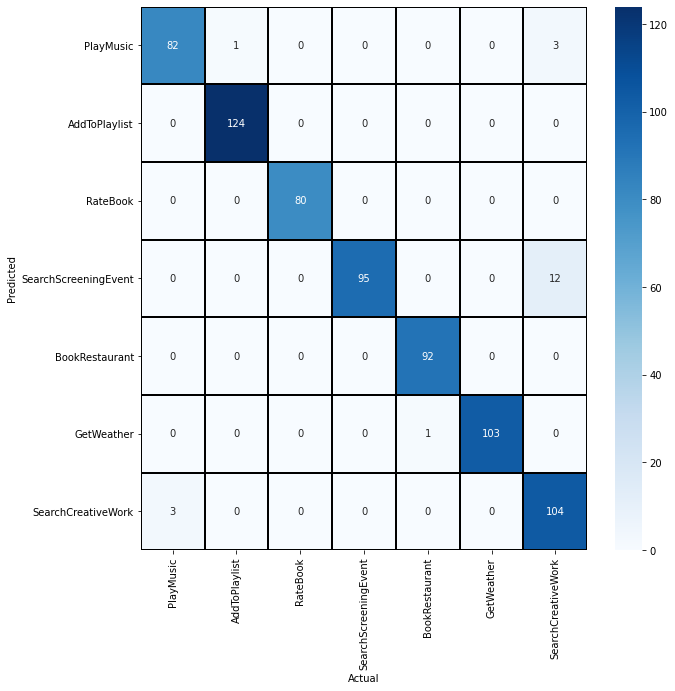

In [60]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", xticklabels = classes, 
           yticklabels = classes,
           linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')

### **Comparison b/w XLNet and BERT models** 

We can see that XLNet model (98% accuracy) outperforms the BERT model (97% accuracy) with test accuracy being 1% higher. However, Training XLNet model required 2 hours for 2 epochs and BERT model took 30 minutes. 